**Predicting Newsletter Subscription Among Minecraft Server Players Using Gameplay Activity**

**Background:**
Minecraft is a popular sandbox video game that allows players to explore, build, and interact within a block-based virtual world. Due to its capability to attract a wide range of players, researchers are using it as a platform for studying behavior.

In this project, a research team at UBC has deployed a custom Minecraft server to collect detailed data on player activity.The server logs their sessions. This behavioral dataset uses variables such as player age and playtime to specifically explore whether players choose to subscribe to a newsletter related to the game based on these conditions. By analyzing these patterns, we aim to build a predictive model that can help identify the most engaged users based on player attributes. By comparing the predictive strength of these two variables, we aim to identify which characteristic better explains subscription behavior, enabling the team to more effectively prioritize either demographic targeting (age) or behavioral targeting (playtime) in future recruitment strategies.

**Question:Is a player’s age or played hours more predictive of whether their subscription to the game-related newsletter?**

**Data Description:**

In [3]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(forcats)
library(repr)
library(themis)
options(repr.matrix.max.rows = 6)
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [5]:
players = read_csv("players.csv")

players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


The players dataset used for this analysis consists of 197 observations and 7 variables. It contains information on players of a Minecraft research server, including demographic details, gameplay statistics, and subscription status.

The key variables are summarized below:

Variable 1 (experience): character — player experience level in minecraft Variable 2 (subscribe): logic — whether or not the player is subscribed to the newsletter (TRUE is subscribed, FALSE is not subscribed) Variable 3 (hashedEmail): character — hashed email of the player to protect privacy Variable 4 (played_hours): numeric (decimal number) — number of hour the player has played Variable 5 (name): character — the name of the player Variable 6 (gender): character — gender of the player Variable 7 (Age): numeric (decimal number) — age of the player in years

The data includes both numeric and categorical variables. The response variable for this analysis is subscribe, which indicates whether a player subscribed to the game-related newsletter.

The data includes both numeric and categorical variables. The response variable for this analysis is subscribe, which indicates whether a player subscribed to the game-related newsletter.

Some considerations about the data:

The dataset may contain missing or inconsistent values, which will be addressed during data cleaning. Certain variables, such as hashedEmail and name, will not be used as predictors. The data were collected through player activity logs and subscription records from the Minecraft research server. Potential limitations include sample size constraints and possible self-reporting bias in demographic variables like gender and age. 

**Methods Description**

In [6]:
players = players|>
as_tibble() |>
select(Age, played_hours, subscribe) |>
filter(played_hours != 0.0) |>
drop_na() |>
 mutate(subscribe = as.factor(subscribe)) |>
 mutate(subscribe = fct_recode(subscribe, "subscribed" = "TRUE", "unsubscribed" = "FALSE"))
players


Age,played_hours,subscribe
<dbl>,<dbl>,<fct>
9,30.3,subscribed
17,3.8,subscribed
21,0.7,subscribed
⋮,⋮,⋮
44,0.1,subscribed
22,0.3,unsubscribed
17,2.3,unsubscribed


Here, I take only the three variables that i need for answering my questions. then, i filter out any rows with the value such as "NA" or "0.0" that are useless values for the data analysis. Lastly, i make sure subsribe is a factor that can later be predicted properly. 

In [7]:
subscribe_true = players |>
filter(subscribe == "subscribed") |>
count(subscribe)
subscribe_true
subscribe_false = players |>
filter(subscribe == "unsubscribed") |>
count(subscribe)
subscribe_false

subscribe,n
<fct>,<int>
subscribed,84


subscribe,n
<fct>,<int>
unsubscribed,25


I first count the number of the two binary types to check if there is a factor imblanace. due to this imbalance, i will oversample subscribe=false in my recipe to balance the two. 

In [8]:
players_recipe <- recipe(subscribe ~ ., data = players) |>
  step_upsample(subscribe, over_ratio = 1, skip = FALSE) |>
prep()
players_clean = bake(players_recipe, players)
players_clean |>
  group_by(subscribe) |>
  summarize(n = n())

subscribe,n
<fct>,<int>
unsubscribed,84
subscribed,84


Here, I rebalanced this factor variable to make sure the imbalance from the data set will not affect my analysis later on. 

Below, I will visualize the data differently to better understand the relationship between my variables, which will aid my analysis later on.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


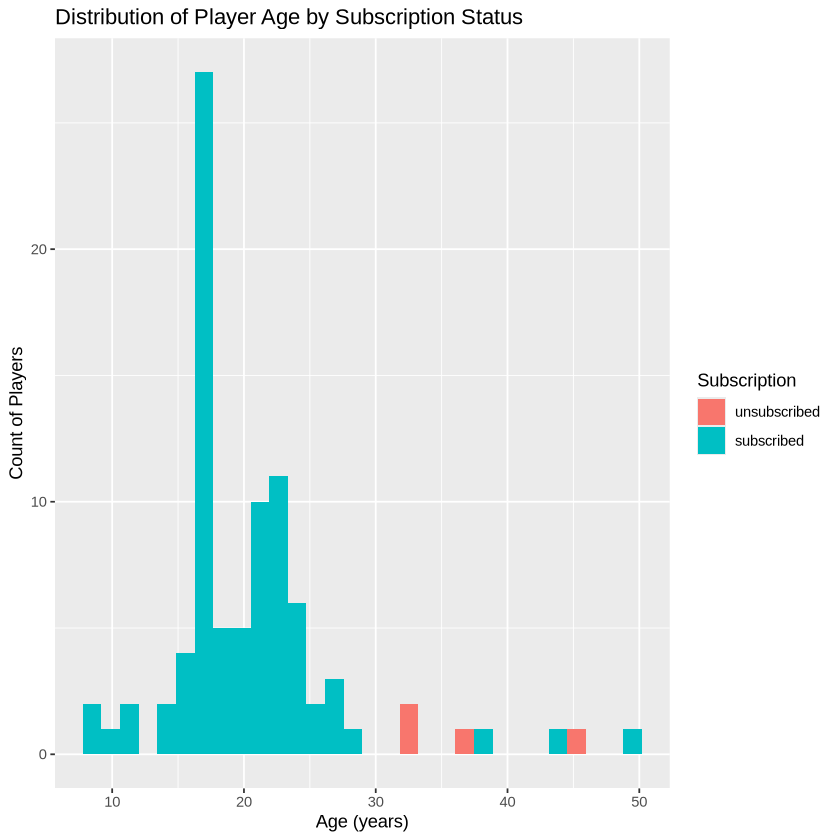

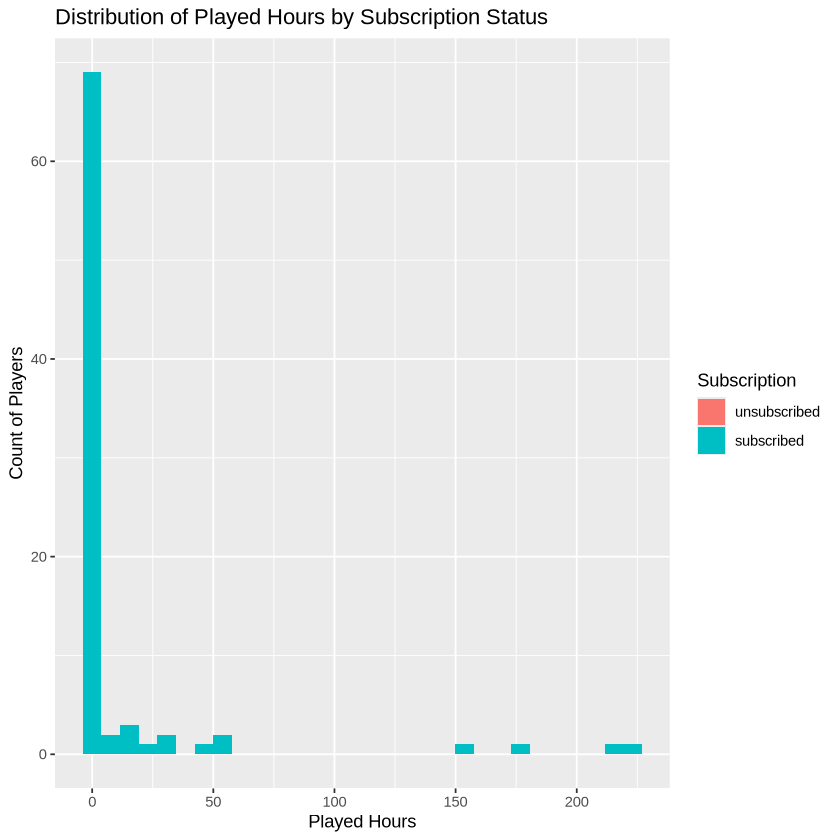

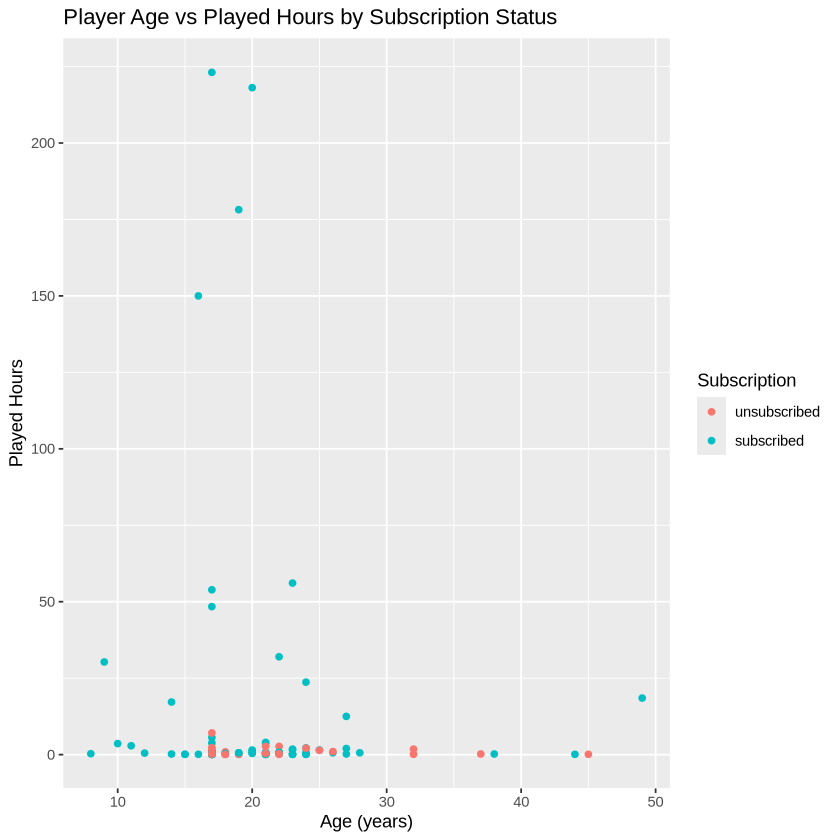

In [9]:
library(ggplot2)

# Histogram of Age by subscription 
ggplot(players, aes(x = Age, fill = subscribe)) +
  geom_histogram(position = "identity") +
  labs(title = "Distribution of Player Age by Subscription Status",
    x = "Age (years)",
    y = "Count of Players",
    fill = "Subscription")
  

# Histogram of Played Hours by subscription 
ggplot(players, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(position = "identity") +
  labs(title = "Distribution of Played Hours by Subscription Status",
    x = "Played Hours",
    y = "Count of Players",
    fill = "Subscription")
 

# Scatterplot of Age vs Played Hours
ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point() +
  labs(title = "Player Age vs Played Hours by Subscription Status",
    x = "Age (years)",
    y = "Played Hours",
    color = "Subscription")



Here, I used the "players" data frame because I didn’t want to rebalance for the exploratory data analysis—I wanted to visualize the data as they already are.

In the histogram for the Distribution of Player Age by Subscription Status, the data is centered around age 30, but the most visible cluster appears between ages 10 and 20. This cluster consists purely of subscribed players, with no apparent unsubscribed players. Unsubscribed players appear from ages 30 to 50 onwards and are much fewer in number compared to players from younger age groups.

In the histogram for the Distribution of Played Hours by Subscription Status, most players cluster around the range of very little playtime, but they were all subscribed to the newsletter. No unsubscribed players were shown on the histogram—they possibly had too little playtime to appear on the plot, or all unsubscribed players did not player in the server(with 0 hour of play time).

In the scatterplot for Player Age vs. Played Hours by Subscription Status, there is no strong relationship between the two variables, as no clear pattern is observed and the plot shows a lot of noise, with points scattered throughout.

Insights from the analysis relative to my predictive questions: 
since there is a distinct seperation by age between subscribed and unsubcribed players,this indicates that age may be a strong predictive value for subscription. Played hours in the second histogram shows no distinction in the subscription groups as unsubcribed players have little to no play time, and they were not shown on the histogram. As a result, I can hypothesize that the existence of any hours played in the server is a strong indicator for the status of subscription. lastly, the scatterplot confirms that the two variables are not correlated, and so it confirms that played time and age together cannot influence their predictive value of subscription. 

**predictive data analysis**

the most appropriate method for prediction is k-nn because the response variable subscribe is binary (yes/no), and i am only using one predictor at a time for the classification. knn works best in these scenarios since it is simple and easy to interpret for analysis that do not involve too many variables and possibilities. 
one of the few assumptions needed for k-nn analysis is that the data collected is reliable, so that the training data can actually be somewhat predictive in the classification. 
I will compare and select the model through 5 fold cross validation at the k range of 1 to 10. after finding out the best neighbor for each and comparing accuracies between the two models, i will then find out the accruacies of the prediction and compare again. Then i will be able to clearly tell is model is better for predicting subsciption of the players.

In [10]:
#I first split the balanced data into training and testing, and also set seed for reproducibility. 
set.seed(1) 

players_split <- initial_split(players_clean, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test  <- testing(players_split)

In [11]:
# Recipe with only age
age_recipe <- recipe(subscribe ~ Age, data = players_train) |>
  step_center(all_predictors()) |>
step_scale(all_predictors())


# Recipe with only played_hours
hours_recipe <- recipe(subscribe ~ played_hours, data = players_train) |>
  step_center(all_predictors()) |>
 step_scale(all_predictors())


In [12]:
#we will start the cross validation to find the best K value. 
#By predicting with the two predictors in two seperate models, we will then better compare which one is better.
subscribe_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)
subscribe_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

#the k value will be found between 1 and 10
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

In [13]:
#workflow for both seperately and find K through the accuracy

#for played hour
hour_result = workflow()|>
add_recipe(hours_recipe) |>
add_model(subscribe_spec) |>
 tune_grid(resamples = subscribe_vfold, grid = k_vals) |>
  collect_metrics() |>
  filter(.metric == "accuracy") |>
slice_max(order_by = mean, n = 1)
hour_result

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
10,accuracy,binary,0.6044872,5,0.0303321,Preprocessor1_Model10


In [14]:
#now I do the same for age
age_result = workflow()|>
add_recipe(age_recipe) |>
add_model(subscribe_spec) |>
 tune_grid(resamples = subscribe_vfold, grid = k_vals) |>
  collect_metrics() |>
  filter(.metric == "accuracy") |>
slice_max(order_by = mean, n = 1)
age_result

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.6570513,5,0.05510584,Preprocessor1_Model09
10,accuracy,binary,0.6570513,5,0.05235261,Preprocessor1_Model10


from this, I can see that the best K value for age is 9, the best for hourrs played is 2(since 1 is too small). 

In [15]:
#now I predict with the given K value 

In [16]:
#hours
hours_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
  set_engine("kknn") |>
  set_mode("classification")

hours_fit <- workflow() |>
  add_recipe(hours_recipe) |>
  add_model(hours_spec) |>
  fit(data = players_train)
hours_test_predictions <- predict(hours_fit, players_test) |>
  bind_cols(players_test)
 # metrics(truth = subscribe, estimate = .pred_class) |>
 #  filter(.metric == "accuracy")  


hours_test_predictions

.pred_class,Age,played_hours,subscribe
<fct>,<dbl>,<dbl>,<fct>
subscribed,37,0.2,unsubscribed
subscribed,17,0.2,unsubscribed
unsubscribed,17,2.3,unsubscribed
⋮,⋮,⋮,⋮
subscribed,17,0.1,subscribed
subscribed,19,0.6,subscribed
subscribed,20,0.5,subscribed


In [17]:
#age
age_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
  set_engine("kknn") |>
  set_mode("classification")

age_fit <- workflow() |>
  add_recipe(age_recipe) |>
  add_model(age_spec) |>
  fit(data = players_train)
age_test_predictions <- predict(age_fit, players_test) |>
  bind_cols(players_test)


age_test_predictions

#test to see the level of the classes 
age_test_predictions |> pull(subscribe) |> levels()


hours_test_predictions |> pull(subscribe) |> levels()





.pred_class,Age,played_hours,subscribe
<fct>,<dbl>,<dbl>,<fct>
unsubscribed,37,0.2,unsubscribed
subscribed,17,0.2,unsubscribed
subscribed,17,2.3,unsubscribed
⋮,⋮,⋮,⋮
subscribed,17,0.1,subscribed
unsubscribed,19,0.6,subscribed
subscribed,20,0.5,subscribed


[1] "unsubscribed" "subscribed"

[1] "unsubscribed" "subscribed"

In [18]:
#above, we see that the postive is at second level
#we will get precision for the two models
age_test_predictions |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "second")

hours_test_predictions |>
 precision(truth = subscribe, estimate = .pred_class, event_level = "second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.5769231


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.6


In [19]:
#we will get recall for the both models
age_test_predictions |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "second")

hours_test_predictions |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "second")


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.7142857


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,1


In [20]:
#we will get accuracy of both models
age_accuracy = age_test_predictions |>
metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")
age_accuracy

hours_accuracy = hours_test_predictions |>
metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")
hours_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5952381


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6666667


In [23]:
#above we see that hours played has a higher accuracy, now we will better visualize it by making a confusion matrix for the models
#confusion matrix for hours played
confusion_hours <- hours_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion_hours

              Truth
Prediction     unsubscribed subscribed
  unsubscribed            7          0
  subscribed             14         21

In [24]:
#confusion matrix for age
confusion_age = age_test_predictions |>
conf_mat(truth = subscribe, estimate = .pred_class) 
confusion_age

              Truth
Prediction     unsubscribed subscribed
  unsubscribed           10          6
  subscribed             11         15

Discussion

Our analysis compared two predictors age and played hours together to see which better predictes whether players subscribed to the newsletter. Using classification models and cross-validation, we found that played hours had a higher prediction accuracy than age. This was first evident in the histogram when a distinct cluster could be seen when subscribed players range from 10 - 20 with players not subscribed in other age ranges, but the histogram for hours player consists purely of players who have subscribed, indicating that players who did not played in the mincraft server all did not subscribe. The histogram for hours played also clusters around 0 hour, indicating that subscription rate does not increase with play time, but rather whether they have played in the server or not.

This result was somewhat unexpected for a different reason from what I hypothesized before the analysis. Intuitively, one might assume that players who spend more time in the game are more engaged and thus more likely to subscribe. Played hours did indicate subsciption, but the prediction power comes from whether or not the player has played in the server rather than the amount they spent playing, which means one can predict just by looking at whether a player has played in the server or not.

Despite hours played is a better predictor, the relationship between age and subscription can still influence how game developers engage with the marketing strategies or their communities. For instance, targeted content or newsletter formats might be adapted for different age groups to increase engagement, and in this case, the target group for marketing should be the age group from 10 to 20. This could lead to the future question of "why almost everyone who played in the server have subscribed?". My analysis offers no explainatory power as to why playing or not in the UBC server is a deterministic characteristic for whether or not people habve subscribed to the newsletter.